# Cook Better data


## ❌ Outdated plan
- Our current data is just general QA as the question and answer is extracted directly from one document
- The plan is to cook better and harder data, about 300 to 500 questions - answers pairs, should be hard that the model need multihop, should take Musique paper as reference. The retrival environment should also be good enough (must be noisy enough)
- Or just training follow related works (use the train set of musique, or nq + hotpotqa)
- For example: ReSearch: "We only use the training set (19938 samples) of MuSiQue for training, and the number of training epochs is 2." -> this is a lot of data compare to our current experiment
- Multiple difficulty level would also be good

### Noise Maker
- Search for "Nguyen Van A" -> got 10 "Nguyen Van A (cook, teacher, police,... etc)" -> the model will be confused and try to correct its query to be more specific
- Ohhh in Musicque paper they call this "Distractor" (20 paragraphs)
-> So bascially we are trying to reinvent the wheel here, but our wheel is not as good as this 💀

### Some meh scenarios
- bro, i gave you the correct passges, but you still get it wrong?? -> must be reading comprehension issue
- bro, you didn't retriveed the correct context passages, but you still able to get the answer right?? -> bro is contaminated
  
- when the model answer wrong, is it because it can not search fo the correct passages? or the correct passges were retrieved but the model still get it wrong? - Thanks @new5558

```
There are 4 main metrics to eval when evaluating RAGS based summarization/deep reserach system.

Context Relevancy: Check if retrieved documents can answer the question
Faithfulness: Check if the result from LLM can be found in the retrived documents
Answer Relevancy: Check if the result from LLM is related to the question
Comparison with answer: Check if the result from LLM is same as the ground truth

All four metrics can be eval using human/llm as a judge.
```

## ✅ Just try musique as this dataset is so peak 🔥
below is the first sample of the dev set of musique (answerable)
- id
- paragraphs
  - **is_supporting**: if true, this paragraph is the supporting evidence for the answer, else it is a distractor
- question: the question
- answer: the answer
- question_decomposition:

> MuSiQue constitutes unique 21020 single-hop questions, 4132 answers to multihop questions, 19841 answers to singlehop questions, and 7676 supporting paragraphs. MuSiQue has 6 types of reasoning graphs and 2-4 hops

-> can categorize: 2 hops -> easy, 3 hops -> medium, 4 hops -> hard
- id structure: xhop_<question_id_1>_<question_id_2>_..._<question_id_x>
- cool prefix: 2hop_, 3hop1, 3hop2, 4hop1, 4hop2, 4hop3
- 2hop, 3hop1, 4hop1 is linear
- 3hop2, 4hop2, 4hop3 is non-linear
- each decomposed question is created from one paragraph, which is nice!
- follow related works, we won't use the decomposition questions, but only the combined question and the final 
- 💡 Not mentioned in other works: beside answer, there is a propety called "answer_aliases", which is a list. -> i think i should make the final answer look like this: "Answer OR Alias01 OR Alias02,..." as we will use llm for correctness, not exact match

for the passages database side:

- what should i do with the title of the support passages??? -> concat them at the beginning of the paragraph, as that's what flashrag return (i should mimic this behavior)
- use faiss, but need to change to the same embedding setting as flashrag (E5-base-v2, bla bla)
- there are random unicode like  "\u2013" in passeges -> need to handle?

### Quick eda train set
Total rows: 19938
Number of unique IDs: 19938 ✅ ok this is legit, same as the paper claimed

Prefix counts:
- 2hop_: 14376
- 3hop2_: 650
- 3hop1_: 3737
- 4hop1_: 648
- 4hop2_: 127
- 4hop3_: 400

Percentage distribution:
- 2hop_: 72.10%
- 3hop2_: 3.26%
- 3hop1_: 18.74%
- 4hop1_: 3.25%
- 4hop2_: 0.64%
- 4hop3_: 2.01%


### Support passages length distribution

- Why am I caculating this? https://unsloth.ai/blog/grpo "Long-context GRPO"

> 1 token ~= 4 chars in English. 1 token ~= ¾ words. 100 tokens ~= 75 words. Or. 1-2 sentence ~= 30 tokens. 1 paragraph ~= 100 tokens. 1,500 words ~= 2048 tokens. - OpenAI

> With a GRPO setup using TRL + FA2, Llama 3.1 (8B) training at 20K context length demands 510.8GB of VRAM. However, Unsloth’s 90% VRAM reduction brings the requirement down to just 54.3GB in the same setup.
- https://github.com/agentica-project/rllm
  > [2025/02/10] We release DeepScaleR-1.5B-Preview, a 1.5B model that surpasses O1-Preview and achieves 43.1% Pass@1 on AIME. We achieve this by iteratively scaling Deepseek's GRPO algorithm from 8K→16K->24K context length for thinking. As part of this release, we open-source: 

  -> **SIZE MATTER! LONGER IS BETTER!**

https://huggingface.co/docs/trl/en/dpo_trainer#trl.DPOTrainer.tokenize_row.max_prompt_length

  Total samples: 19938
Answerable samples: 19938 (100.00%)
Samples with non-empty answer_aliases: 5067 (25.41%)

Paragraph length statistics (words):
  Min: 19
  Max: 299
  ℹ️ℹ️ Mean: 79.02 -> **~ 100 - 110 tokens -> k5 -> 500 - 600 tokens for 1 query -> 4 hops -> 2000 ~ 2500 tokens (happy scenario when the model was able to complete in 4 hops)**
  Median: 68.00

Paragraph length statistics (characters):
  Min: 100
  Max: 2000
  Mean: 481.69
  Median: 414.00

Title length statistics (words):
  Min: 1
  Max: 23
  Mean: 2.98
  Median: 3.00

Answer length statistics (words):
  Min: 1
  Max: 14
  Mean: 2.42
  Median: 2.00

Question length statistics (words):
  Min: 4
  Max: 46
  Mean: 15.96
  Median: 15.00

Question length statistics (characters):
  Min: 29
  ℹ️ℹ️ℹ Max: 283 -> the prompt is currently about 200 words long -> plus this is about 500 - 600 max_prompt_tokens for just starting prompt. but the prompt size will gradually increase as the agent loop continue (think + query + docs)
  Mean: 89.97
  Median: 83.00

Question length by hop count (words):
  2hop: 13.91 words (n=14376)
  3hop: 19.85 words (n=4387)
  4hop: 26.56 words (n=1175)

Unique characters in questions (lowercased):
 !"#$&'()+,-./0123456789:;=?[]`abcdefghijklmnopqrstuvwxyz£²×ßàáâãäåçèéêëìíïñòóôõöøúüýāăćčđēěğģīıłńňōřśşšũūżžșțə̇ạầặếễệọốộủỳ​–—‘’

Unique characters in answers (lowercased):
 "$%&'()+,-./0123456789:`abcdefghijklmnopqrstuvwxyz¡¢£¤¥§¨©ª¬­°±³¶¸ºáâãäæè
 - bro wtf is ""????

- 600 system + 50 (think) + 600 (infor) + 50 (think) + 600 (info) ..... 
- ---------------1----------------------------2------------------------- -> 650 for each genrations ->
- 24k: max_generations from 32 to 36 should be good
- 16k: max_generations from 20 to 24 should be good
- 8k: 10 to 12 generations should be good 

## ✅ Feel the data 

In [2]:
# Quick id distribution
import json
import os
from collections import Counter

# Path to the jsonl file
file_path = "../data/raw/musique_ans_v1.0_train.jsonl"

# Initialize counters
total_rows = 0
unique_ids = set()
prefix_counts = Counter()

# Read the jsonl file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        total_rows += 1
        data = json.loads(line)
        unique_ids.add(data["id"])

        # Count prefixes
        for prefix in ["2hop_", "3hop1_", "3hop2_", "4hop1_", "4hop2_", "4hop3_"]:
            if data["id"].startswith(prefix):
                prefix_counts[prefix] += 1
                break

# Print results
print(f"Total rows: {total_rows}")
print(f"Number of unique IDs: {len(unique_ids)}")
print("\nPrefix counts:")
for prefix, count in prefix_counts.items():
    print(f"- {prefix}: {count}")

# Calculate percentage for each prefix
print("\nPercentage distribution:")
for prefix, count in prefix_counts.items():
    percentage = (count / total_rows) * 100
    print(f"- {prefix}: {percentage:.2f}%")


Total rows: 19938
Number of unique IDs: 19938

Prefix counts:
- 2hop_: 14376
- 3hop2_: 650
- 3hop1_: 3737
- 4hop1_: 648
- 4hop2_: 127
- 4hop3_: 400

Percentage distribution:
- 2hop_: 72.10%
- 3hop2_: 3.26%
- 3hop1_: 18.74%
- 4hop1_: 3.25%
- 4hop2_: 0.64%
- 4hop3_: 2.01%


/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\)'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\,'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\m'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\s'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\e'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape sequence '\p'
  text = para['paragraph_text'].encode().decode('unicode_escape')
/tmp/ipykernel_529125/527129310.py:78: DeprecationWarning: invalid escape se

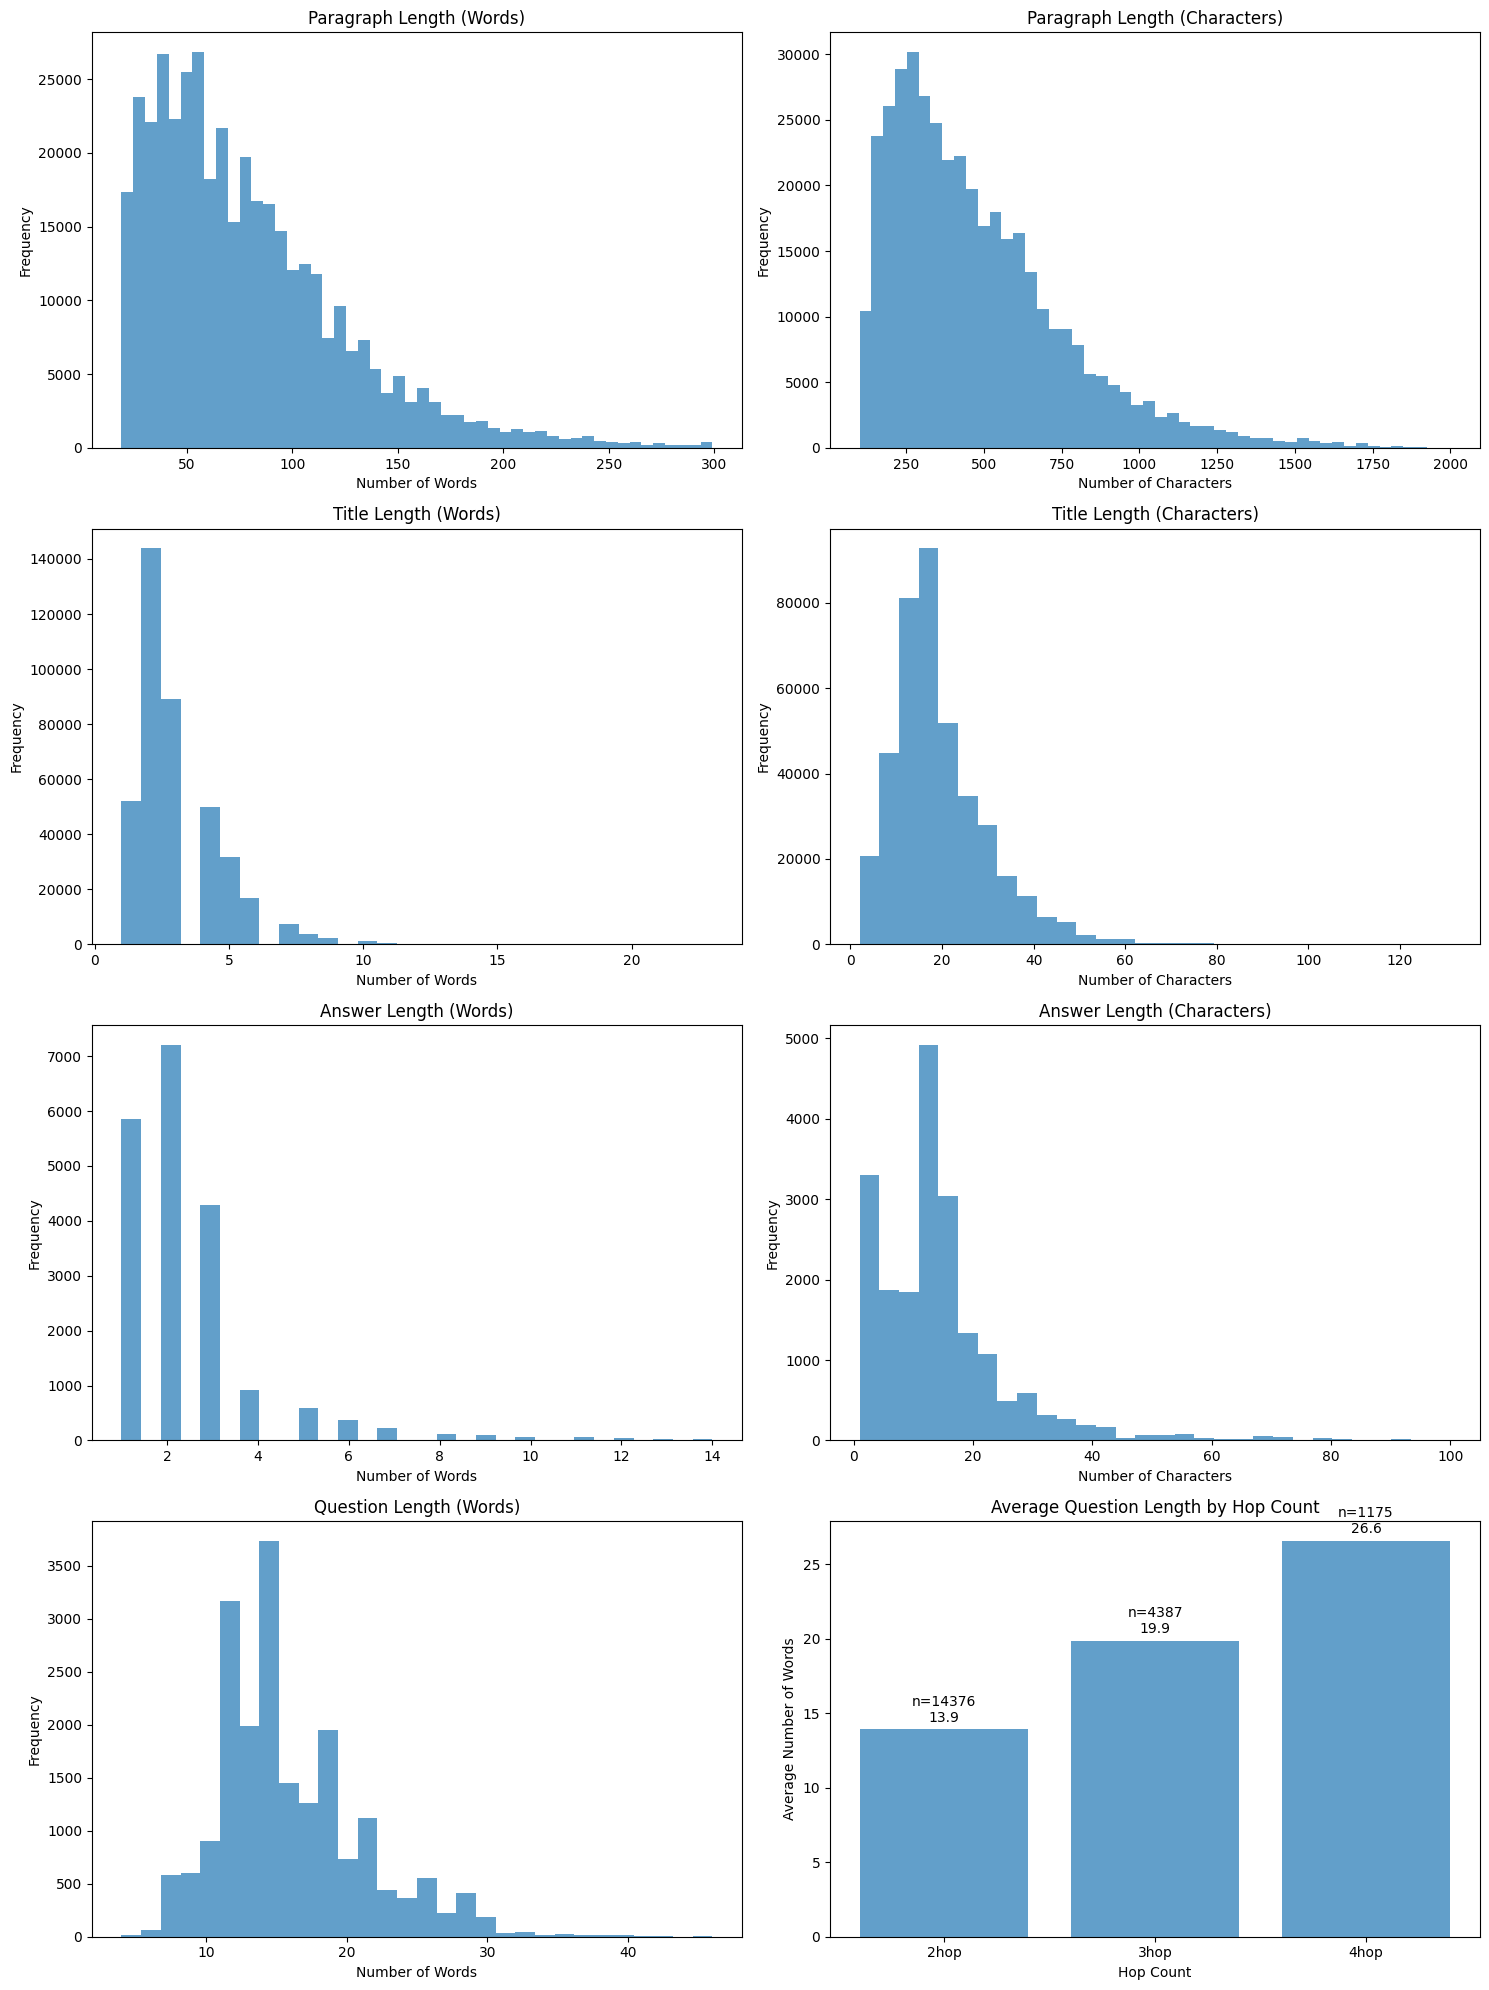

Total samples: 19938
Answerable samples: 19938 (100.00%)
Samples with non-empty answer_aliases: 5067 (25.41%)

Paragraph length statistics (words):
  Min: 19
  Max: 299
  Mean: 79.02
  Median: 68.00

Paragraph length statistics (characters):
  Min: 100
  Max: 2000
  Mean: 481.69
  Median: 414.00

Title length statistics (words):
  Min: 1
  Max: 23
  Mean: 2.98
  Median: 3.00

Question length statistics (words):
  Min: 4
  Max: 46
  Mean: 15.96
  Median: 15.00

Question length statistics (characters):
  Min: 29
  Max: 283
  Mean: 89.97
  Median: 83.00

Question length by hop count (words):
  2hop: 13.91 words (n=14376)
  3hop: 19.85 words (n=4387)
  4hop: 26.56 words (n=1175)

Answer length statistics (words):
  Min: 1
  Max: 14
  Mean: 2.42
  Median: 2.00

Unique characters in questions (lowercased):
 !"#$&'()+,-./0123456789:;=?[]`abcdefghijklmnopqrstuvwxyz£²×ßàáâãäåçèéêëìíïñòóôõöøúüýāăćčđēěğģīıłńňōřśşšũūżžșțə̇ạầặếễệọốộủỳ​–—‘’

Unique characters in answers (lowercased):
 "$%&'()+,-./01

In [33]:
# length distribution of support passages
import matplotlib.pyplot as plt
import numpy as np
import re

# Path to the jsonl file
file_path = "../data/raw/musique_ans_v1.0_train.jsonl"

# Initialize lists to store lengths
para_word_lengths = []
para_char_lengths = []
title_word_lengths = []
title_char_lengths = []
answer_word_lengths = []
answer_char_lengths = []
question_word_lengths = []
question_char_lengths = []
non_empty_aliases_count = 0
question_chars = set()
answer_chars = set()
answerable_count = 0
total_samples = 0

# For hop analysis
hop_question_lengths = {"2hop": [], "3hop": [], "4hop": []}

# Read the jsonl file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        total_samples += 1

        # Check if answerable
        if data.get("answerable", False):
            answerable_count += 1

        # Check answer aliases
        if data.get("answer_aliases") and len(data["answer_aliases"]) > 0:
            non_empty_aliases_count += 1

        # Collect unique characters in questions and answers
        if "question" in data:
            question = data["question"]
            question_chars.update(question.lower())

            # Count words and characters in question
            question_words = question.split()
            question_word_lengths.append(len(question_words))
            question_char_lengths.append(len(question))

            # Extract hop count from ID for analysis
            if "id" in data:
                if data["id"].startswith("2hop"):
                    hop_question_lengths["2hop"].append(len(question_words))
                elif data["id"].startswith("3hop"):
                    hop_question_lengths["3hop"].append(len(question_words))
                elif data["id"].startswith("4hop"):
                    hop_question_lengths["4hop"].append(len(question_words))

        if "answer" in data:
            # Handle unicode escape sequences
            answer = data["answer"].encode().decode("unicode_escape")
            answer_chars.update(answer.lower())

            # Count words and characters in answer
            answer_words = answer.split()
            answer_word_lengths.append(len(answer_words))
            answer_char_lengths.append(len(answer))

        # Process paragraphs
        for para in data.get("paragraphs", []):
            if "paragraph_text" in para:
                # Handle unicode escape sequences
                text = para["paragraph_text"].encode().decode("unicode_escape")
                words = text.split()
                para_word_lengths.append(len(words))
                para_char_lengths.append(len(text))

            if "title" in para:
                # Handle unicode escape sequences
                title = para["title"].encode().decode("unicode_escape")
                title_words = title.split()
                title_word_lengths.append(len(title_words))
                title_char_lengths.append(len(title))

# Create a figure with subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot paragraph length distributions
axs[0, 0].hist(para_word_lengths, bins=50, alpha=0.7)
axs[0, 0].set_title("Paragraph Length (Words)")
axs[0, 0].set_xlabel("Number of Words")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(para_char_lengths, bins=50, alpha=0.7)
axs[0, 1].set_title("Paragraph Length (Characters)")
axs[0, 1].set_xlabel("Number of Characters")
axs[0, 1].set_ylabel("Frequency")

# Plot title length distributions
axs[1, 0].hist(title_word_lengths, bins=30, alpha=0.7)
axs[1, 0].set_title("Title Length (Words)")
axs[1, 0].set_xlabel("Number of Words")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(title_char_lengths, bins=30, alpha=0.7)
axs[1, 1].set_title("Title Length (Characters)")
axs[1, 1].set_xlabel("Number of Characters")
axs[1, 1].set_ylabel("Frequency")

# Plot answer length distributions
axs[2, 0].hist(answer_word_lengths, bins=30, alpha=0.7)
axs[2, 0].set_title("Answer Length (Words)")
axs[2, 0].set_xlabel("Number of Words")
axs[2, 0].set_ylabel("Frequency")

axs[2, 1].hist(answer_char_lengths, bins=30, alpha=0.7)
axs[2, 1].set_title("Answer Length (Characters)")
axs[2, 1].set_xlabel("Number of Characters")
axs[2, 1].set_ylabel("Frequency")

# Plot question length distributions
axs[3, 0].hist(question_word_lengths, bins=30, alpha=0.7)
axs[3, 0].set_title("Question Length (Words)")
axs[3, 0].set_xlabel("Number of Words")
axs[3, 0].set_ylabel("Frequency")

# Plot question length by hop count
hop_labels = ["2hop", "3hop", "4hop"]
hop_means = [np.mean(hop_question_lengths[hop]) for hop in hop_labels]
hop_counts = [len(hop_question_lengths[hop]) for hop in hop_labels]

axs[3, 1].bar(hop_labels, hop_means, alpha=0.7)
axs[3, 1].set_title("Average Question Length by Hop Count")
axs[3, 1].set_xlabel("Hop Count")
axs[3, 1].set_ylabel("Average Number of Words")

# Add count labels on top of bars
for i, (count, mean) in enumerate(zip(hop_counts, hop_means)):
    axs[3, 1].text(i, mean + 0.5, f"n={count}\n{mean:.1f}", ha="center")

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total samples: {total_samples}")
print(f"Answerable samples: {answerable_count} ({answerable_count / total_samples * 100:.2f}%)")
print(
    f"Samples with non-empty answer_aliases: {non_empty_aliases_count} ({non_empty_aliases_count / total_samples * 100:.2f}%)"
)

# Print paragraph length statistics
print("\nParagraph length statistics (words):")
print(f"  Min: {min(para_word_lengths)}")
print(f"  Max: {max(para_word_lengths)}")
print(f"  Mean: {np.mean(para_word_lengths):.2f}")
print(f"  Median: {np.median(para_word_lengths):.2f}")

print("\nParagraph length statistics (characters):")
print(f"  Min: {min(para_char_lengths)}")
print(f"  Max: {max(para_char_lengths)}")
print(f"  Mean: {np.mean(para_char_lengths):.2f}")
print(f"  Median: {np.median(para_char_lengths):.2f}")

# Print title length statistics
print("\nTitle length statistics (words):")
print(f"  Min: {min(title_word_lengths)}")
print(f"  Max: {max(title_word_lengths)}")
print(f"  Mean: {np.mean(title_word_lengths):.2f}")
print(f"  Median: {np.median(title_word_lengths):.2f}")

# Print question length statistics
print("\nQuestion length statistics (words):")
print(f"  Min: {min(question_word_lengths)}")
print(f"  Max: {max(question_word_lengths)}")
print(f"  Mean: {np.mean(question_word_lengths):.2f}")
print(f"  Median: {np.median(question_word_lengths):.2f}")

print("\nQuestion length statistics (characters):")
print(f"  Min: {min(question_char_lengths)}")
print(f"  Max: {max(question_char_lengths)}")
print(f"  Mean: {np.mean(question_char_lengths):.2f}")
print(f"  Median: {np.median(question_char_lengths):.2f}")

# Print question length by hop count
print("\nQuestion length by hop count (words):")
for hop in hop_labels:
    print(f"  {hop}: {np.mean(hop_question_lengths[hop]):.2f} words (n={len(hop_question_lengths[hop])})")

# Print answer length statistics
print("\nAnswer length statistics (words):")
print(f"  Min: {min(answer_word_lengths)}")
print(f"  Max: {max(answer_word_lengths)}")
print(f"  Mean: {np.mean(answer_word_lengths):.2f}")
print(f"  Median: {np.median(answer_word_lengths):.2f}")

# Print unique characters
print("\nUnique characters in questions (lowercased):")
print("".join(sorted(question_chars)))

print("\nUnique characters in answers (lowercased):")
print("".join(sorted(answer_chars)))


In [31]:
# Find samples with suspicious characters in questions and answers
import json
import random

# Define suspicious characters (non-ASCII and special characters)
suspicious_chars = ""


# Function to check if text contains any suspicious characters
def contains_suspicious_chars(text, chars_to_check):
    return any(char in text for char in chars_to_check)


# Lists to store samples with suspicious characters
question_samples = []
answer_samples = []

# Read the jsonl file again to find examples
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)

        # Check question
        if "question" in data and contains_suspicious_chars(data["question"].lower(), suspicious_chars):
            question_samples.append(
                {
                    "id": data.get("id", "unknown"),
                    "question": data["question"],
                    "suspicious_chars": [char for char in data["question"] if char.lower() in suspicious_chars],
                }
            )

        # Check answer
        if "answer" in data and contains_suspicious_chars(data["answer"].lower(), suspicious_chars):
            answer_samples.append(
                {
                    "id": data.get("id", "unknown"),
                    "answer": data["answer"],
                    "suspicious_chars": [char for char in data["answer"] if char.lower() in suspicious_chars],
                }
            )

# Print some samples with suspicious characters in questions
print(f"Found {len(question_samples)} samples with suspicious characters in questions")
if question_samples:
    samples_to_show = min(5, len(question_samples))
    print(f"\nShowing {samples_to_show} random samples with suspicious characters in questions:")
    for sample in random.sample(question_samples, samples_to_show):
        print(f"ID: {sample['id']}")
        print(f"Question: {sample['question']}")
        print(f"Suspicious characters: {', '.join(set(sample['suspicious_chars']))}")
        print()

# Print some samples with suspicious characters in answers
print(f"Found {len(answer_samples)} samples with suspicious characters in answers")
if answer_samples:
    samples_to_show = min(5, len(answer_samples))
    print(f"\nShowing {samples_to_show} random samples with suspicious characters in answers:")
    for sample in random.sample(answer_samples, samples_to_show):
        print(f"ID: {sample['id']}")
        print(f"Answer: {sample['answer']}")
        print(f"Suspicious characters: {', '.join(set(sample['suspicious_chars']))}")
        print()


Found 0 samples with suspicious characters in questions
Found 0 samples with suspicious characters in answers


### Actually touch some samples

In [ ]:
{
    "id": "2hop__460946_294723",
    "paragraphs": [
        {
            "idx": 0,
            "title": "Grant's First Stand",
            "paragraph_text": 'Grant\'s First Stand is the debut album by American jazz guitarist Grant Green featuring performances by Green recorded and released on the Blue Note label in 1961. Earlier recordings made by Green for Blue Note were released as "First Session" in 2001.',
            "is_supporting": false,
        },
        {
            "idx": 1,
            "title": "List of show business families",
            "paragraph_text": "Actress / director / singer Phylicia Rash\u0101d is the older sister of performer Debbie Allen, who is married to former NBA basketball player, Norm Nixon. Phylicia Rash\u0101d is the former spouse of both Victor Willis, former lead singer of the group Village People, and former NFL football player turned sportscaster, Ahmad Rash\u0101d. Phylicia and Ahmad Rash\u0101d are the parents of actress Condola Rash\u0101d.",
            "is_supporting": false,
        },
        {
            "idx": 5,
            "title": "Miquette Giraudy",
            "paragraph_text": "Miquette Giraudy (born 9 February 1953, Nice, France) is a keyboard player and vocalist, best known for her work in Gong and with her partner Steve Hillage. She and Hillage currently form the core of the ambient band System 7. In addition to her performances in music, she has also worked as an actress, film editor and writer. In each role, she has used different stage names.",
            "is_supporting": true,
        },
        ...
        {
            "idx": 19,
            "title": "Mok Kwai-lan",
            "paragraph_text": "Mok Kwai-lan (; October 15, 1892 \u2013 November 3, 1982) was the fourth spouse of Lingnan martial arts grandmaster Wong Fei-hung.",
            "is_supporting": false,
        },
    ],
    "question": "Who is the spouse of the Green performer?",
    "question_decomposition": [
        {"id": 460946, "question": "Green >> performer", "answer": "Steve Hillage", "paragraph_support_idx": 10},
        {"id": 294723, "question": "#1 >> spouse", "answer": "Miquette Giraudy", "paragraph_support_idx": 5},
    ],
    "answer": "Miquette Giraudy",
    "answer_aliases": [],
    "answerable": true,
}

In [ ]:
{
    "id": "3hop1__145427_106426_77199",
    "paragraphs": [
        {
            "idx": 0,
            "title": "USA Up All Night",
            "paragraph_text": "USA Up All Night (also known as Up All Night and Up All Night with Rhonda Shear) is an American cable television series that aired weekly on Friday and Saturday nights on the USA Network. The show aired from 1989 to 1998.",
            "is_supporting": false,
        },
        {
            "idx": 1,
            "title": "Pasadena Society of Artists",
            "paragraph_text": "The Pasadena Society of Artists, founded in 1925, is one of the longest-running, nonprofit arts organizations in the state of California, USA.",
            "is_supporting": false,
        },
        {
            "idx": 2,
            "title": "Franco-Prussian War",
            "paragraph_text": 'While the republican government was amenable to war reparations or ceding colonial territories in Africa or in South East Asia to Prussia, Favre on behalf of the Government of National Defense, declared on 6 September that France would not "yield an inch of its territory nor a stone of its fortresses." The republic then renewed the declaration of war, called for recruits in all parts of the country and pledged to drive the German troops out of France by a guerre \u00e0 outrance. Under these circumstances, the Germans had to continue the war, yet could not pin down any proper military opposition in their vicinity. As the bulk of the remaining French armies were digging-in near Paris, the German leaders decided to put pressure upon the enemy by attacking Paris. By September 15, German troops reached the outskirts of the fortified city. On September 19, the Germans surrounded it and erected a blockade, as already established at Metz.',
            "is_supporting": false,
        },
        {
            "idx": 3,
            "title": "The Longest Night in Shanghai",
            "paragraph_text": "The Longest Night in Shanghai () is a 2007 film produced by Japan's Movie Eye Entertainment and directed by Chinese director Zhang Yibai. It is a rare collaboration between China and Japan.",
            "is_supporting": true,
        },
        {
            "idx": 4,
            "title": "Declaration of war by the United States",
            "paragraph_text": "The last time the United States declared war on any nation was in 1942, when war was declared against Axis - allied Hungary, Bulgaria, and Romania, because President Franklin Roosevelt thought it was improper to engage in hostilities against a country without a declaration of war. Since then, every American president has used military force without a declaration of war.",
            "is_supporting": false,
        },
        {
            "idx": 5,
            "title": "John Trumbull Birthplace",
            "paragraph_text": "The John Trumbull Birthplace, also known as the Governor Jonathan Trumbull House, is a historic house museum on the Lebanon Green in Lebanon, Connecticut. Built in 1735 by Joseph Trumbull as a wedding present for his son Jonathan (1710-1785), the house was a center of political and military strategy during the American Revolutionary War, when Jonathan Trumbull was Governor of Connecticut. It was also the birthplace of John Trumbull (1756-1843), an artist known for his depictions of the war and its people. The house was designated a National Historic Landmark in 1965.",
            "is_supporting": false,
        },
        {
            "idx": 6,
            "title": "Annibale Bergonzoli",
            "paragraph_text": 'Annibale Bergonzoli (1 November 1884 \u2013 31 July 1973), nicknamed ""barba elettrica"", "Electric Whiskers", was an Italian Lieutenant General who served during World War I, the Spanish Civil War and World War II. In 1940 he commanded the defences of Bardia, Libya. In February 1941, after the disastrous Battle of Beda Fomm, Bergonzoli surrendered to Australian forces. He was held as a prisoner in India and the USA before being repatriated to Italy. Bergonzoli settled in his birthplace, Cannobio, and died there in 1973.',
            "is_supporting": false,
        },
        {
            "idx": 7,
            "title": "Allies of World War II",
            "paragraph_text": "The Allies of World War II, called the United Nations from the 1 January 1942 declaration, were the countries that together opposed the Axis powers during the Second World War (1939 -- 1945). The Allies promoted the alliance as seeking to stop German, Japanese and Italian aggression.",
            "is_supporting": false,
        },
        {
            "idx": 8,
            "title": "Mardi Gras in the United States",
            "paragraph_text": "In 1875, the state of Louisiana declared Mardi Gras a legal holiday. Economic, political, and weather conditions sometimes led to the cancellation of some or all of the major parades, especially during the American Civil War, World War I and World War II, but Carnival has always been observed in the city in some way.",
            "is_supporting": false,
        },
        {
            "idx": 9,
            "title": "Shirley Plantation",
            "paragraph_text": "Shirley Plantation is an estate located on the north bank of the James River in Charles City County, Virginia, USA. It is located on State Route 5, a scenic byway which runs between the independent cities of Richmond and Williamsburg. Shirley Plantation is the oldest active plantation in Virginia and is the oldest family-owned business in North America, dating back to 1614 with operations starting in 1638. The plantation was added to the National Register in 1969 and declared a National Historic Landmark in 1970.",
            "is_supporting": false,
        },
        {
            "idx": 10,
            "title": "Military history of the United States during World War II",
            "paragraph_text": "On 11 December 1941, Adolf Hitler and Nazi Germany declared war against the United States, the same day that the United States declared war on Germany and Italy.",
            "is_supporting": false,
        },
        {
            "idx": 11,
            "title": "San Miguel de Allende",
            "paragraph_text": "San Miguel de Allende (Spanish pronunciation: (san mi'\u0263el de a'\u028eende)) is a city and municipality located in the far eastern part of the state of Guanajuato in central Mexico. It is part of the macroregion of Baj\u00edo. It is 274 km (170 mi) from Mexico City, 86 km (53 mi) from Queretaro, and 97 km (60 mi) from the state capital of Guanajuato. Historically, the town is important as being the birthplace of Mexican General Ignacio Allende, whose surname was added to the town's name in 1826, as well as the first municipality declared independent of Spanish rule by the nascent insurgent army during the Mexican War of Independence. San Miguel de Allende was also a critical epicenter during the historic Chichimeca War (1540 - 1590) where the Chichimeca Confederation defeated the Spanish Empire in the initial colonization war. Today, the town is a proclaimed World Heritage Site, attracting thousands of tourists and new residents from abroad every year.",
            "is_supporting": false,
        },
        {
            "idx": 12,
            "title": "One Thrilling Night",
            "paragraph_text": "The newlywed country bumpkins from Connecticut, Mr. and Mrs. Horace Jason (John Beal and Wanda McKay), check into the Hotel Clarke in New York City, prepared to spend their first night together as a married couple. It is also their first and last night before Horace joins the Army.",
            "is_supporting": false,
        },
        {
            "idx": 13,
            "title": "Battle of the Atlantic",
            "paragraph_text": "The Battle of the Atlantic was the longest continuous military campaign in World War II, running from 1939 to the defeat of Nazi Germany in 1945, and was a major part of the Naval history of World War II. At its core was the Allied naval blockade of Germany, announced the day after the declaration of war, and Germany's subsequent counter-blockade. It was at its height from mid-1940 through to the end of 1943.",
            "is_supporting": false,
        },
        {
            "idx": 14,
            "title": "Francis Scott Key Bridge (Baltimore)",
            "paragraph_text": "The Francis Scott Key Bridge, also known as the Outer Harbor Bridge or simply the Key Bridge, is a steel arch-shaped continuous through truss bridge spanning the Patapsco River in Baltimore, Maryland, USA. The main span of is the third longest span of any continuous truss in the world. It is also the longest bridge in the Baltimore area.",
            "is_supporting": false,
        },
        {
            "idx": 15,
            "title": "Military history of Italy during World War II",
            "paragraph_text": "On 10 June 1940, as the French government fled to Bordeaux during the German invasion, declaring Paris an open city, Mussolini felt the conflict would soon end and declared war on Britain and France. As he said to the Army's Chief - of - Staff, Marshal Badoglio:",
            "is_supporting": false,
        },
        {
            "idx": 16,
            "title": "Sandia Peak Tramway",
            "paragraph_text": "The Sandia Peak Tramway is an aerial tramway located adjacent to Albuquerque, New Mexico, USA. It stretches from the northeast edge of the city to the crestline of the Sandia Mountains and has the world's third longest single span. It is the longest aerial tram in the United States.",
            "is_supporting": false,
        },
        {
            "idx": 17,
            "title": "United States declaration of war on Japan",
            "paragraph_text": "On December 8, 1941, the United States Congress declared war (Public Law 77 - 328, 55 STAT 795) on the Empire of Japan in response to that country's surprise attack on Pearl Harbor the prior day. It was formulated an hour after the Infamy Speech of US President Franklin D. Roosevelt. Japan had sent a message for the United States to its embassy in Washington earlier, but because of problems at the embassy in decoding the very long message -- the high security level assigned to the declaration meant that only personnel with very high clearances could decode it, which slowed down the process -- it was not delivered to the U.S. Secretary of State until after the Pearl Harbor attack. Following the U.S. declaration, Japan's allies, Germany and Italy, declared war on the United States, bringing the United States fully into World War II.",
            "is_supporting": true,
        },
        {
            "idx": 18,
            "title": "Faces of War Memorial",
            "paragraph_text": "Faces Of War Memorial is a Vietnam War memorial located in Roswell, Georgia, USA. It is located on the grounds of Roswell City Hall and was dedicated on January 1, 1998.",
            "is_supporting": false,
        },
        {
            "idx": 19,
            "title": "You Wenhui",
            "paragraph_text": "You Wenhui (; born October 20, 1979 in Shanghai) is a female Chinese beach volleyball player who competed in the 2004 Summer Olympics.",
            "is_supporting": true,
        },
    ],
    "question": "When did the USA declare war on the country that produced The Longest Night in the city where You Wenhui was born?",
    "question_decomposition": [
        {
            "id": 145427,
            "question": "Which city was the birthplace of You Wenhui?",
            "answer": "Shanghai",
            "paragraph_support_idx": 19,
        },
        {
            "id": 106426,
            "question": "Which was the country for The Longest Night in #1 ?",
            "answer": "Japan",
            "paragraph_support_idx": 3,
        },
        {
            "id": 77199,
            "question": "when did the usa declare war on #2",
            "answer": "December 8, 1941",
            "paragraph_support_idx": 17,
        },
    ],
    "answer": "December 8, 1941",
    "answer_aliases": [],
    "answerable": true,
}


In [ ]:
{
    "id": "3hop2__101905_30152_20999",
    "paragraphs": [
        {
            "idx": 0,
            "title": "Somalis",
            "paragraph_text": "In addition, the Somali community has produced numerous important Muslim figures over the centuries, many of whom have significantly shaped the course of Islamic learning and practice in the Horn of Africa, the Arabian Peninsula and well beyond.",
            "is_supporting": false,
        },
        {
            "idx": 1,
            "title": "Umayyad Caliphate",
            "paragraph_text": "Non-Muslim groups in the Umayyad Caliphate, which included Christians, Jews, Zoroastrians, and pagan Berbers, were called dhimmis. They were given a legally protected status as second-class citizens as long as they accepted and acknowledged the political supremacy of the ruling Muslims. They were allowed to have their own courts, and were given freedom of their religion within the empire.[citation needed] Although they could not hold the highest public offices in the empire, they had many bureaucratic positions within the government. Christians and Jews still continued to produce great theological thinkers within their communities, but as time wore on, many of the intellectuals converted to Islam, leading to a lack of great thinkers in the non-Muslim communities.",
            "is_supporting": false,
        },
        {
            "idx": 2,
            "title": "Somalis",
            "paragraph_text": "Somalis (Somali: Soomaali, Arabic: \u0635\u0648\u0645\u0627\u0644\u200e) are an ethnic group inhabiting the Horn of Africa (Somali Peninsula). The overwhelming majority of Somalis speak the Somali language, which is part of the Cushitic branch of the Afro-Asiatic family. They are predominantly Sunni Muslim. Ethnic Somalis number around 16-20 million and are principally concentrated in Somalia (around 12.3 million), Ethiopia (4.6 million), Kenya (2.4 million), and Djibouti (464,600), with many also residing in parts of the Middle East, North America and Europe.",
            "is_supporting": false,
        },
        {
            "idx": 3,
            "title": "Visa requirements for New Zealand citizens",
            "paragraph_text": "Visa requirements for New Zealand citizens are administrative entry restrictions by the authorities of other states placed on citizens of New Zealand. As of 1 January 2017, New Zealand citizens had visa - free or visa on arrival access to 172 countries and territories, ranking the New Zealand passport 5th in terms of travel freedom (tied with Irish and Japanese passports) according to the Henley visa restrictions index.",
            "is_supporting": false,
        },
        {
            "idx": 4,
            "title": "Ottoman Empire",
            "paragraph_text": "The discovery of new maritime trade routes by Western European states allowed them to avoid the Ottoman trade monopoly. The Portuguese discovery of the Cape of Good Hope in 1488 initiated a series of Ottoman-Portuguese naval wars in the Indian Ocean throughout the 16th century. The Somali Muslim Ajuran Empire, allied with the Ottomans, defied the Portuguese economic monopoly in the Indian Ocean by employing a new coinage which followed the Ottoman pattern, thus proclaiming an attitude of economic independence in regard to the Portuguese.",
            "is_supporting": true,
        },
        {
            "idx": 5,
            "title": "Somalis",
            "paragraph_text": "Somali people in the Horn of Africa are divided among different countries (Somalia, Djibouti, Ethiopia, and northeastern Kenya) that were artificially and some might say arbitrarily partitioned by the former imperial powers. Pan-Somalism is an ideology that advocates the unification of all ethnic Somalis once part of Somali empires such as the Ajuran Empire, the Adal Sultanate, the Gobroon Dynasty and the Dervish State under one flag and one nation. The Siad Barre regime actively promoted Pan-Somalism, which eventually led to the Ogaden War between Somalia on one side, and Ethiopia, Cuba and the Soviet Union on the other.",
            "is_supporting": false,
        },
        {
            "idx": 6,
            "title": "Communications in Somalia",
            "paragraph_text": "There are a number of radio news agencies based in Somalia. Established during the colonial period, Radio Mogadishu initially broadcast news items in both Somali and Italian. The station was modernized with Russian assistance following independence in 1960, and began offering home service in Somali, Amharic and Oromo. After closing down operations in the early 1990s due to the civil war, the station was officially re-opened in the early 2000s by the Transitional National Government. In the late 2000s, Radio Mogadishu also launched a complementary website of the same name, with news items in Somali, Arabic and English.",
            "is_supporting": false,
        },
        {
            "idx": 7,
            "title": "Somalis",
            "paragraph_text": "Following World War II, Britain retained control of both British Somaliland and Italian Somaliland as protectorates. In 1945, during the Potsdam Conference, the United Nations granted Italy trusteeship of Italian Somaliland, but only under close supervision and on the condition \u2014 first proposed by the Somali Youth League (SYL) and other nascent Somali political organizations, such as Hizbia Digil Mirifle Somali (HDMS) and the Somali National League (SNL) \u2014 that Somalia achieve independence within ten years. British Somaliland remained a protectorate of Britain until 1960.",
            "is_supporting": false,
        },
        {
            "idx": 8,
            "title": "Somalis in the United Kingdom",
            "paragraph_text": "Somalis in the United Kingdom include British citizens and residents born in, or with ancestors from, Somalia. It is thought that the United Kingdom (UK) is home to the largest Somali community in Europe, with an estimated 98,000 Somali - born immigrants residing in the UK in 2016 according to the Office for National Statistics. The majority of these live in England, with the largest number found in London. Smaller Somali communities exist in Birmingham, Bristol, Manchester, Liverpool, Leicester, Milton Keynes, Sheffield and Cardiff.",
            "is_supporting": false,
        },
        {
            "idx": 9,
            "title": "Somalis",
            "paragraph_text": "The history of Islam in Somalia is as old as the religion itself. The early persecuted Muslims fled to various places in the region, including the city of Zeila in modern-day northern Somalia, so as to seek protection from the Quraysh. Somalis were among the first populations on the continent to embrace Islam. With very few exceptions, Somalis are entirely Muslims, the majority belonging to the Sunni branch of Islam and the Shafi`i school of Islamic jurisprudence, although a few are also adherents of the Shia Muslim denomination.",
            "is_supporting": false,
        },
        {
            "idx": 10,
            "title": "Portugal",
            "paragraph_text": "The land within the borders of current Portugal has been continuously settled and fought over since prehistoric times. The Celts and the Romans were followed by the Visigothic and the Suebi Germanic peoples, who were themselves later invaded by the Moors. These Muslim peoples were eventually expelled during the Christian Reconquista of the peninsula. By 1139, Portugal had established itself as a kingdom independent from Le\u00f3n. In the 15th and 16th centuries, as the result of pioneering the Age of Discovery, Portugal expanded Western influence and established the first global empire, becoming one of the world's major economic, political and military powers.",
            "is_supporting": false,
        },
        {
            "idx": 11,
            "title": "Myanmar",
            "paragraph_text": "The dynasty regrouped and defeated the Portuguese in 1613 and Siam in 1614. It restored a smaller, more manageable kingdom, encompassing Lower Myanmar, Upper Myanmar, Shan states, Lan Na and upper Tenasserim. The Restored Toungoo kings created a legal and political framework whose basic features would continue well into the 19th century. The crown completely replaced the hereditary chieftainships with appointed governorships in the entire Irrawaddy valley, and greatly reduced the hereditary rights of Shan chiefs. Its trade and secular administrative reforms built a prosperous economy for more than 80 years. From the 1720s onward, the kingdom was beset with repeated Meithei raids into Upper Myanmar and a nagging rebellion in Lan Na. In 1740, the Mon of Lower Myanmar founded the Restored Hanthawaddy Kingdom. Hanthawaddy forces sacked Ava in 1752, ending the 266-year-old Toungoo Dynasty.",
            "is_supporting": true,
        },
        {
            "idx": 12,
            "title": "Somalis",
            "paragraph_text": "The Somali flag is an ethnic flag conceived to represent ethnic Somalis. It was created in 1954 by the Somali scholar Mohammed Awale Liban, after he had been selected by the labour trade union of the Trust Territory of Somalia to come up with a design. Upon independence in 1960, the flag was adopted as the national flag of the nascent Somali Republic. The five-pointed Star of Unity in the flag's center represents the Somali ethnic group inhabiting the five territories in Greater Somalia.",
            "is_supporting": false,
        },
        {
            "idx": 13,
            "title": "Muslim world",
            "paragraph_text": "More than 20% of the world's population is Muslim. Current estimates conclude that the number of Muslims in the world is around 1,5 billion. Muslims are the majority in 49 countries, they speak hundreds of languages and come from diverse ethnic backgrounds. Major languages spoken by Muslims include Arabic, Urdu, Bengali, Punjabi, Malay, Javanese, Sundanese, Swahili, Hausa, Fula, Berber, Tuareg, Somali, Albanian, Bosnian, Russian, Turkish, Azeri, Kazakh, Uzbek, Tatar, Persian, Kurdish, Pashto, Balochi, Sindhi and Kashmiri, among many others.",
            "is_supporting": false,
        },
        {
            "idx": 14,
            "title": "Somalis",
            "paragraph_text": "The birth of Islam on the opposite side of Somalia's Red Sea coast meant that Somali merchants, sailors and expatriates living in the Arabian Peninsula gradually came under the influence of the new religion through their converted Arab Muslim trading partners. With the migration of fleeing Muslim families from the Islamic world to Somalia in the early centuries of Islam and the peaceful conversion of the Somali population by Somali Muslim scholars in the following centuries, the ancient city-states eventually transformed into Islamic Mogadishu, Berbera, Zeila, Barawa and Merca, which were part of the Berberi civilization. The city of Mogadishu came to be known as the City of Islam, and controlled the East African gold trade for several centuries.",
            "is_supporting": false,
        },
        {
            "idx": 15,
            "title": "Mint (facility)",
            "paragraph_text": "At about the same time, coins and mints appeared independently in China and spread to Korea and Japan. The manufacture of coins in the Roman Empire, dating from about the 4th century BC, significantly influenced later development of coin minting in Europe.",
            "is_supporting": false,
        },
        {
            "idx": 16,
            "title": "Somalis",
            "paragraph_text": "Growing out of the Somali people's rich storytelling tradition, the first few feature-length Somali films and cinematic festivals emerged in the early 1960s, immediately after independence. Following the creation of the Somali Film Agency (SFA) regulatory body in 1975, the local film scene began to expand rapidly. The Somali filmmaker Ali Said Hassan concurrently served as the SFA's representative in Rome. In the 1970s and early 1980s, popular musicals known as riwaayado were the main driving force behind the Somali movie industry. Epic and period films as well as international co-productions followed suit, facilitated by the proliferation of video technology and national television networks. Said Salah Ahmed during this period directed his first feature film, The Somali Darwish (The Somalia Dervishes), devoted to the Dervish State. In the 1990s and 2000s, a new wave of more entertainment-oriented movies emerged. Referred to as Somaliwood, this upstart, youth-based cinematic movement has energized the Somali film industry and in the process introduced innovative storylines, marketing strategies and production techniques. The young directors Abdisalam Aato of Olol Films and Abdi Malik Isak are at the forefront of this quiet revolution.",
            "is_supporting": false,
        },
        {
            "idx": 17,
            "title": "Somalis",
            "paragraph_text": "In 1975, the most prominent government reforms regarding family law in a Muslim country were set in motion in the Somali Democratic Republic, which put women and men, including husbands and wives, on complete equal footing. The 1975 Somali Family Law gave men and women equal division of property between the husband and wife upon divorce and the exclusive right to control by each spouse over his or her personal property.",
            "is_supporting": false,
        },
        {
            "idx": 18,
            "title": "Germans",
            "paragraph_text": "After World War II, eastern European countries such as the Soviet Union, Poland, Czechoslovakia, Hungary, Romania and Yugoslavia expelled the Germans from their territories. Many of those had inhabited these lands for centuries, developing a unique culture. Germans were also forced to leave the former eastern territories of Germany, which were annexed by Poland (Silesia, Pomerania, parts of Brandenburg and southern part of East Prussia) and the Soviet Union (northern part of East Prussia). Between 12 and 16,5 million ethnic Germans and German citizens were expelled westwards to allied-occupied Germany.",
            "is_supporting": false,
        },
        {
            "idx": 19,
            "title": "David Htan",
            "paragraph_text": "David Htan (; born 13 May 1990) is a burmese professional footballer who plays as a midfielder for Myanmar national football team and Shan United. David Htan suddenly moved to Shan United F.C. in May 2018.",
            "is_supporting": true,
        },
    ],
    "question": "How were the people that the Ajuran Empire declared independence from by minting coins expelled from David Htan's country?",
    "question_decomposition": [
        {
            "id": 101905,
            "question": "Of what country is David Htan a citizen?",
            "answer": "Myanmar",
            "paragraph_support_idx": 19,
        },
        {
            "id": 30152,
            "question": "New coins were a proclamation of independence by the Somali Muslim Ajuran Empire from whom?",
            "answer": "the Portuguese",
            "paragraph_support_idx": 4,
        },
        {
            "id": 20999,
            "question": "How were the #2 expelled from #1 ?",
            "answer": "The dynasty regrouped and defeated the Portuguese",
            "paragraph_support_idx": 11,
        },
    ],
    "answer": "The dynasty regrouped and defeated the Portuguese",
    "answer_aliases": [],
    "answerable": true,
}


In [ ]:
# example 4 hop - original
{
    "id": "4hop2__160585_14670_8987_8974",
    "paragraphs": [
        {
            "idx": 0,
            "title": "United States Army",
            "paragraph_text": "Currently, the army is divided into the Regular Army, the Army Reserve, and the Army National Guard. The army is also divided into major branches such as Air Defense Artillery, Infantry, Aviation, Signal Corps, Corps of Engineers, and Armor. Before 1903 members of the National Guard were considered state soldiers unless federalized (i.e., activated) by the President. Since the Militia Act of 1903 all National Guard soldiers have held dual status: as National Guardsmen under the authority of the governor of their state or territory and, when activated, as a reserve of the U.S. Army under the authority of the President.",
            "is_supporting": true,
        },
        {
            "idx": 1,
            "title": "Iron Beam",
            "paragraph_text": 'Iron Beam (, "") is an air defense system which is in development by Israeli defense contractor Rafael Advanced Defense Systems. Unveiled at the Singapore Air Show on February 11, 2014. The system is designed to destroy short-range rockets, artillery, and mortars with a range of up to , too small for the Iron Dome system to intercept effectively. In addition, the system could also intercept unmanned aerial vehicles. Iron Beam will use a "directed high energy laser beam" to destroy hostile targets with ranges of up to . Iron Beam will constitute the fifth element of Israel\'s integrated air defense system, in addition to Arrow 2, Arrow 3, David\'s Sling, and Iron Dome. However, Iron Beam is also a stand-alone system.',
            "is_supporting": false,
        },
        ...
        {
            "idx": 19,
            "title": "Josip Broz Tito",
            "paragraph_text": "In 1968, Tito offered Czechoslovak leader Alexander Dub\u010dek to fly to Prague on three hours notice if Dub\u010dek needed help in facing down the Soviets. In April 1969, Tito removed generals Ivan Go\u0161njak and Rade Hamovi\u0107 in the aftermath of the invasion of Czechoslovakia due to the unpreparedness of the Yugoslav army to respond to a similar invasion of Yugoslavia.",
            "is_supporting": true,
        },
    ],
    "question": "Hana Mandlikova was born in Country A that invaded Country B because the military branch the Air Defense Artillery is part of was unprepared. Country B was the only communist country to have an embassy where?",
    "question_decomposition": [
        {
            "id": 160585,
            "question": "Where was Hana Mandlikova born?",
            "answer": "Czechoslovakia",
            "paragraph_support_idx": 15,
        },
        {
            "id": 14670,
            "question": "The Air Defense Artillery is a branch of what?",
            "answer": "the Army",
            "paragraph_support_idx": 0,
        },
        {
            "id": 8987,
            "question": "What #2 was unprepared for the invasion of #1 ?",
            "answer": "Yugoslavia",
            "paragraph_support_idx": 19,
        },
        {
            "id": 8974,
            "question": "#3 was the only communist country to have an embassy where?",
            "answer": "Alfredo Stroessner's Paraguay",
            "paragraph_support_idx": 2,
        },
    ],
    "answer": "Alfredo Stroessner's Paraguay",
    "answer_aliases": ["Alfredo Stroessner"],
    "answerable": true,
}

# example format  - desired
{
    "id": "4hop2__160585_14670_8987_8974",
    "question": "Hana Mandlikova was born in Country A that invaded Country B because the military branch the Air Defense Artillery is part of was unprepared. Country B was the only communist country to have an embassy where?",
    "answer": "Alfredo Stroessner's Paraguay",
    "supporting_paragraphs": [ # this is the list of paragraphs that is_supporting=True
        "Currently, the army is divided into the Regular Army, the Army Reserve, and the Army National Guard. The army is also divided into major branches such as Air Defense Artillery, Infantry, Aviation, Signal Corps, Corps of Engineers, and Armor. Before 1903 members of the National Guard were considered state soldiers unless federalized (i.e., activated) by the President. Since the Militia Act of 1903 all National Guard soldiers have held dual status: as National Guardsmen under the authority of the governor of their state or territory and, when activated, as a reserve of the U.S. Army under the authority of the President.",
        "bla bla bla",
        "bla bla bla",
        "In 1968, Tito offered Czechoslovak leader Alexander Dub\u010dek to fly to Prague on three hours notice if Dub\u010dek needed help in facing down the Soviets. In April 1969, Tito removed generals Ivan Go\u0161njak and Rade Hamovi\u0107 in the aftermath of the invasion of Czechoslovakia due to the unpreparedness of the Yugoslav army to respond to a similar invasion of Yugoslavia.",
    ]
},

# quick check from the script:
{"id": "4hop1__337568_570923_833580_61459", 
 "question": "One of the actors in a Pound of Flesh is from a European county whose king Albert I lived during a major war. When did Italy enter that war?", "answer": "1915", "supporting_paragraphs": ["The Queen Elisabeth Medical Foundation (QEMF) is a Belgian non-profit organization, founded in 1926 by Elisabeth of Bavaria, wife of Albert I. She founded the organization, based on her experience with the wounded from the front-line during the First World War. The foundation wants to encourage laboratory research and contacts between researchers and clinical practitioners, with a particular focus on neurosciences. The QEMF supports seventeen university teams throughout Belgium.", "On 3 May 1915 Italy officially revoked the Triple Alliance. In the following days Giolitti and the neutralist majority of the Parliament opposed declaring war, while nationalist crowds demonstrated in public areas for it. (The nationalist poet Gabriele D'Annunzio called this period le radiose giornate di Maggio -- ``the sunny days of May ''). Giolitti had the support of the majority of Italian parliament so on 13 May Salandra offered his resignation to King Victor Emmanuel III, but then Giolitti learned that the London Pact was already signed: fearful of a conflict between the Crown and the Parliament and the consequences on both internal stability and foreign relationships, Giolitti accepted the fait accompli, declined to succeed as prime minister and Salandra's resignation was not accepted. On 23 May, Italy declared war on Austria - Hungary. This was followed by declarations of war on the Ottoman Empire (21 August 1915, following an ultimatum of 3 August), Bulgaria (19 October 1915) and the German Empire (28 August 1916).", "JCVD is a 2008 Belgian crime drama film directed by French Tunisian film director Mabrouk el Mechri, and starring Jean-Claude van Damme as a semi-fictionalized version of himself, a down and out action star whose family and career are crumbling around him as he is caught in the middle of a post office heist in his hometown of Brussels, Belgium.", "Pound of Flesh is a 2015 Canadian action thriller film directed by Ernie Barbarash, and starring Jean-Claude Van Damme and Darren Shahlavi. It is the third collaboration between Van Damme and Barbarash (following \"Assassination Games\" in 2011 and \"Six Bullets\" in 2012)."]}


# also,  need a script to extract all paragraphs from the original data  (ensure they are unique) 
# FROM ALL TRAIN DEV TEST SPLIT
# to a simple csv file like this. 
# chunk_id should be incremental (good enough, since there is no chunk_id in the original data)
# title is the title of the paragraph
# content is the text of the paragraph
# metadata is a list of original question_id that this paragraph is supporting (just for backward compatibility with previous data format)
"""
chunk_id,content,metadata
1, Bla bla bla, bla bla bla, [2hop_xxx_xxx, ....]
"""

# then the an faiss index will be generated from this csv file with intfloat/e5-base-v2 embedding model

# remember the distribution of the number of hops?

## Inspect think length of related works
### Search-R1 ~ 20 words
- <think> I need to find out which city and state a singer, by whom the women’s fragrance ”Curious” was created, was born in. </think>
- <think> I need to find out which city and state Britney Spears, the singer behind ”Curious” fragrance, was born in. </think>
- <think> Since Britney Spears was born in McComb, Mississippi, I need to find out which city and state that is. </think>
### R1-Seacher ~ 30 - 40 words
- To solve this question, I need to find out who the president of the United States was in the year that Citibank was founded and then identify that president. Step 1: Determine the year Citibank was founded. I’ll use a search query to find out:
- From the search results, I can see that Citibank was founded in 1812. Step 2: Identify the president of the United States in 1812. I’ll use a search query to find out:
### ReSearch 30 - 60 words - also make the most sense!
- To find the answer, I first need to determine the country in which Martín Ramírez Pech’s political party operates. I will search for "Martín Ramírez Pech" to find out this information.
- It appears that I made a mistake in my search query. Instead of searching for "Martín Ramírez Pech", the results are showing information about a different "Martín Ramírez". To find out the right information, I need to look for Martín Ramírez Pech specifically and the political party associated with him. I will modify the search query to "Martín Ramírez Pech political party" for the correct information. 
- Now, we see that Martín Ramírez Pech is associated with the political party known as the Labor Party (PT) in Mexico. I now need to continue this line of reasoning to find out who won the presidential election in 2018 in Mexico. 

### Ours (DeepSearch 250404) ~30 - 40 words (holyf didn't expect this to be this good) 
- Q: The flag of the territory that Harry Collinge High School is located in is a subclass of what? (taken from test set of musique)
- The information about Harry Collinge High School is required to answer this question. The school is located in the territory of Jersey, a self-governing island within the British Crown.
- Based on the provided information about the flag of Jersey, it is clear that the flag of Jersey is the British Red Ensign with a distinctive design.
- Based on the information about the flag of Jersey, it seems that the flag is a subclass of the flag of the United Kingdom, specifically the British Red Ensign, but with additional design elements.
- Based on the information about the Red Ensign, it seems that the British Red Ensign is a subclass of the flag of the United Kingdom, which includes the Union Jack.
- Based on the information about the Union Jack, it seems that the Union Jack is the flag of the United Kingdom, which is a subclass of the flag of the British Commonwealth, but more broadly, it is a subclass of the flag of the United Kingdom's predecessor, the Kingdom of Great Britain.
- Based on the information about the flag of Great Britain, it seems that the flag of Great Britain is the precursor to the Union Jack of 1801, and it was used as the flag of the Kingdom of Great Britain from 1707 to 1801.
- ℹ️ℹ️ TOKEN LIMIT EXCEEDED (After Iteration): Current 4950, Start 315 -> IT"S SCALE UP TIME!



## New Plan
- scirpt to prepare musicque (download, unzip, move to the right place, dev subset, bla bla)
- script to turn musicque into our format
- trainning goes brrrr

In [22]:
# Test DeepScaleR-1.5B to see its thinking process
from transformers.pipelines import pipeline

pipe = pipeline("text-generation", model="agentica-org/DeepScaleR-1.5B-Preview", device="cuda:1", max_length=8192)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 26.84it/s]
Device set to use cuda:1


In [27]:
# LOL for this question it took 4,5 minutes to generate the reponse and not yet have the answer (set max_length=8192)
question = """
Each vertex of a regular octagon is independently colored either red or blue with equal probability. The probability that the octagon can then be rotated so that all of the blue vertices end up at positions where there were originally red vertices is $\tfrac{m}{n}$, where $m$ and $n$ are relatively prime positive integers. What is $m+n$?
"""
print(pipe(question))


[{'generated_text': "\n\nEach vertex of a regular octagon is independently colored either red or blue with equal probability. The probability that the octagon can then be rotated so that all of the blue vertices end up at positions where there were originally red vertices is $\tfrac{m}{n}$, where $m$ and $n$ are relatively prime positive integers. What is $m+n$?\n</think><think>\nOkay, let's try to tackle this problem step by step. It seems a bit involved, but maybe breaking it down will help.\n\nWe have a regular octagon, each vertex is colored either red or blue independently with equal probability. So each vertex has a 50% chance of being red or blue.\n\nThe question is about the probability that after some rotation, all the blue vertices end up where the original red vertices were. In other words, the blue vertices must be moved to positions where the original red ones were. Since it's a regular octagon, the rotations that can make this possible are the symmetries of the octagon, w